In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import utils
from whitelists import *
import top_crates
import functools

# Configure pyplot: enlarge plots 
plt.rcParams['figure.figsize'] = [15, 8]
# Configure pandas: show all columns when printing a dataframe
pd.set_option('display.max_columns', None)
# Configure pandas: show more rows when printing a dataframe
pd.set_option('display.min_rows', 20)

In [2]:
# Load tables
function_definitions = utils.load_selected_function_definitions()
raw_function_unsafe_reasons = utils.load_unsafe_reasons_in_function_definitions()
unsafe_block_calls = utils.load_unsafe_block_calls()
const_calls = utils.load_const_calls()
unsafe_blocks = utils.load_unsafe_blocks()
traits = utils.load_selected_traits()
traits_impls = utils.load_selected_impl_definitions()
type_defs = utils.load_selected_type_defs()
adts = utils.load_selected_adts()
adt_field_types = utils.load_selected_adt_field_types()
selected_builds = utils.load_selected_builds()

In [3]:
# Cleanup: remove duplicates
raw_function_unsafe_reasons = raw_function_unsafe_reasons.drop_duplicates()

# Remove functions that are not in function_definitions
raw_function_unsafe_reasons = raw_function_unsafe_reasons[
    raw_function_unsafe_reasons.def_path.isin(set(function_definitions.def_path.unique()))
]

possible_unsafe_reasons = [
    "call to unsafe function",
    "use of inline assembly",
    "initializing type with `rustc_layout_scalar_valid_range` attr",
    "cast of pointer to int",
    "pointer operation",
    "borrow of packed field",
    "use of mutable static",
    "use of extern static",
    "dereference of raw pointer",
    "assignment to non-`Copy` union field",
    "access to union field",
    "mutation of layout constrained field",
    "borrow of layout constrained field with interior mutability",
]

# Map reasons -> number
function_unsafe_reasons = raw_function_unsafe_reasons[
    ["crate_name", "crate_hash", "def_path", "unsafe_reason"]
].groupby("def_path").agg(frozenset).rename(
    columns={'unsafe_reason': 'unsafe_reasons'}
)

function_unsafe_reasons["unsafe_reasons_vec"] = function_unsafe_reasons.unsafe_reasons.map(
    lambda x: [reason in x for reason in possible_unsafe_reasons]
)
function_unsafe_reasons["num_unsafe_reasons"] = function_unsafe_reasons.unsafe_reasons_vec.map(sum)

for reason in possible_unsafe_reasons:
    function_unsafe_reasons[reason] = function_unsafe_reasons.unsafe_reasons.map(
        lambda x: reason in x
    )

# Augment const calls made from unsafe blocks
unsafe_block_const_calls = unsafe_block_calls.join(
    const_calls.set_index("call"),
    on="call",
    how="inner",
    rsuffix="_defsite",
)
# Rename confusing columns
unsafe_block_const_calls.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)

# Preprocessing
crates = pd.DataFrame({
    "crate": selected_builds.crate,
    "crate_hash": selected_builds.crate_hash,
    "package": selected_builds.package.map(lambda x: str(x).lower().replace("-", "_")),
})
user_written_unsafe_blocks = unsafe_blocks[unsafe_blocks.check_mode == "UnsafeBlockUserProvided"]
unsafe_function_definitions = function_definitions[function_definitions.unsafety == "Unsafe"]
unsafe_traits = traits[traits.unsafety == "Unsafe"]
unsafe_traits_impls = traits_impls[traits_impls.unsafety == "Unsafe"]

# Whitelists
all_function_names = set(function_definitions.def_path.unique())
unchecked_function_names = get_unchecked_function_names(all_function_names)
unguarded_function_names = get_unguarded_function_names(all_function_names)

all_calls = utils.load_all_calls()
unsafe_calls = all_calls.query("unsafety != 'Normal'")
assert len(pd.unique(unsafe_calls.unsafety)) == 1

In [4]:
len(selected_builds)

510

Number of crates: 510
has_no_unsafe             259
has_unsafe                251
has_unsafe_blocks         220
has_unsafe_functions      165
has_unsafe_trait_impls     73
has_unsafe_traits          25
dtype: int64
has_no_unsafe             50.784314
has_unsafe                49.215686
has_unsafe_blocks         43.137255
has_unsafe_functions      32.352941
has_unsafe_trait_impls    14.313725
has_unsafe_traits          4.901961
dtype: float64


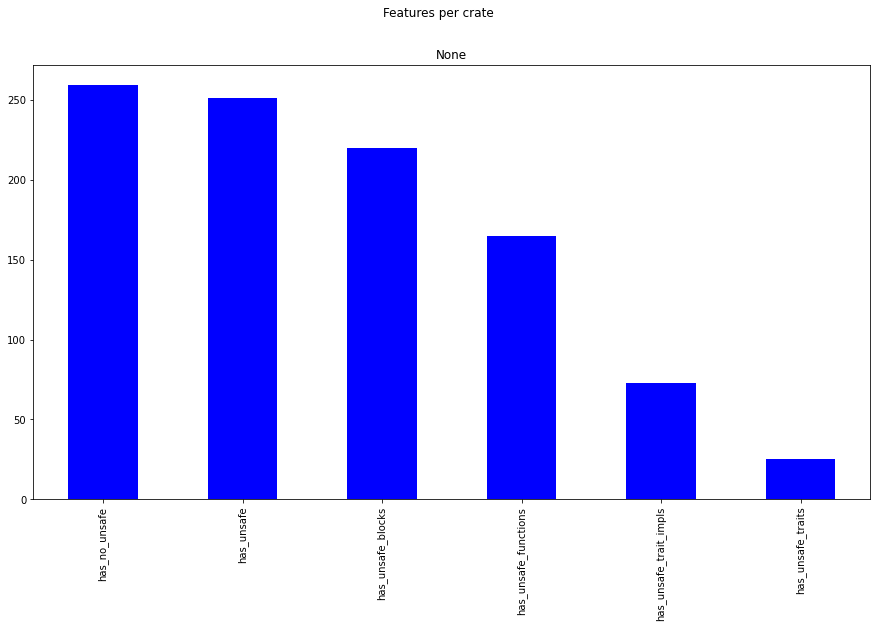

In [5]:
join_key = "crate_hash"
crates["has_unsafe_blocks"] = crates[join_key].isin(set(user_written_unsafe_blocks[join_key].unique()))
crates["has_unsafe_functions"] = crates[join_key].isin(set(unsafe_function_definitions[join_key].unique()))
crates["has_unsafe_traits"] = crates[join_key].isin(set(unsafe_traits[join_key].unique()))
crates["has_unsafe_trait_impls"] = crates[join_key].isin(set(unsafe_traits_impls[join_key].unique()))

feature_names = [
    "has_unsafe_blocks",
    "has_unsafe_functions",
    "has_unsafe_traits",
    "has_unsafe_trait_impls",
]

crates["has_unsafe"] = functools.reduce(lambda x, y: x | y, [crates[f] for f in feature_names])
feature_names.append("has_unsafe")

crates["has_no_unsafe"] = ~crates["has_unsafe"]
feature_names.append("has_no_unsafe")

print("Number of crates: {}".format(len(crates)))

feature_freq = crates[feature_names].apply(sum).sort_values(ascending=False)
feature_freq.plot.bar(subplots=True, color="blue", title="Features per crate")
print(feature_freq)
print(feature_freq / len(crates) * 100)

In [6]:
print(len(unsafe_blocks))
print(len(user_written_unsafe_blocks))
print(len(unsafe_function_definitions))
print(len(unsafe_traits))
print(len(unsafe_traits_impls))

11333
7331
6353
64
1431


ForeignItem    3478
Rust           2699
C               176
Name: abi, dtype: int64
ForeignItem    54.745789
Rust           42.483866
C               2.770345
Name: abi, dtype: float64
Unsafe function definitions: 6353


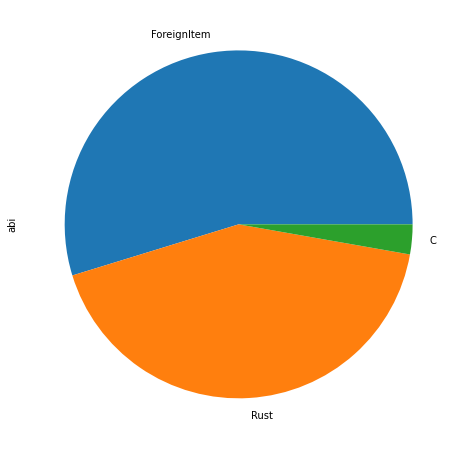

In [7]:
# Frequency of abi DEFINITIONS
values = unsafe_function_definitions.abi.value_counts()
print(values)
print(values / len(unsafe_function_definitions) * 100)
print("Unsafe function definitions:", len(unsafe_function_definitions))
values.plot.pie()
del values

In [8]:
# Which crates define unsafe Rust functions?
def_unsafe_rust_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "Rust"
]

values = def_unsafe_rust_funcs.crate.value_counts()

print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Names and counts of 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values

Number of crates that define unsafe Rust functions:	 146
Names and counts of 20 crates with most defined unsafe Rust functions:

js_sys             803
futures_util       121
git2               108
tokio               84
openssl             80
nix                 79
blake2b_simd        77
wasm_bindgen        70
cloudabi            66
core_foundation     58
wasi                45
openssl_sys         42
aho_corasick        41
tendril             40
hermit_abi          39
widestring          38
hashbrown           34
rayon_core          33
ascii               33
bytes               33
Name: crate, dtype: int64


In [9]:
# Which crates define C functions?
def_c_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "C"
]

values = def_c_funcs.crate.value_counts()

print("Number of crates that define C functions:\t", len(values))
print("Names and counts:")
print()
print(values)
del values

Number of crates that define C functions:	 7
Names and counts:

wasm_bindgen          96
miniz_oxide_c_api     31
libc                  27
openssl               18
security_framework     2
backtrace              1
ring                   1
Name: crate, dtype: int64


In [10]:
# Which crates define Foreign Items?
def_fi_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "ForeignItem"
]

values = def_fi_funcs.crate.value_counts()

print("Number of crates that define Foreign Items:\t", len(values))
print("Names and counts of 20 crates with most defined Foreign Items:")
print()
print(values[:20])
del values

Number of crates that define Foreign Items:	 31
Names and counts of 20 crates with most defined Foreign Items:

openssl_sys               733
libc                      702
libgit2_sys               593
clang_sys                 288
core_foundation_sys       230
libsqlite3_sys            174
fuchsia_zircon_sys        139
libssh2_sys                96
ring                       74
security_framework_sys     57
libz_sys                   56
hermit_abi                 55
lzma_sys                   52
cloudabi                   49
wasi                       45
curl_sys                   44
brotli_sys                 23
termios                    13
crypto                      9
xattr                       8
Name: crate, dtype: int64


Rust              7844
C                 2242
rust-intrinsic     644
Name: abi, dtype: int64
Rust              73.103448
C                 20.894688
rust-intrinsic     6.001864
Name: abi, dtype: float64
Unsafe calls: 10730


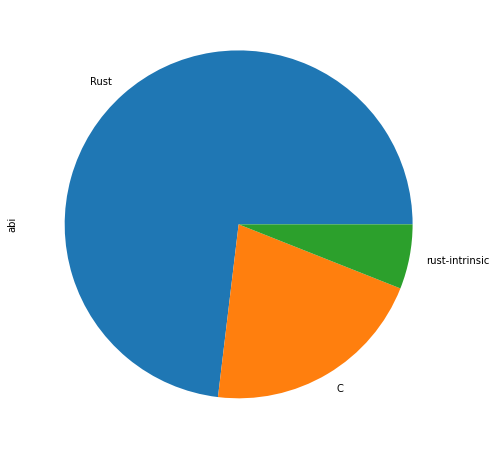

In [11]:
# Frequency of abi CALLS
unsafe_const_calls = const_calls[
    const_calls.unsafety == "Unsafe"
]
values = unsafe_const_calls.abi.value_counts()
print(values)
print(values / len(unsafe_const_calls) * 100)
print("Unsafe calls:", len(unsafe_const_calls))
values.plot.pie()
del values

In [12]:
# Which crates call unsafe Rust functions?
calls_unsafe_rust_funcs = unsafe_const_calls[
    unsafe_const_calls.abi == "Rust"
]

values = calls_unsafe_rust_funcs.crate.value_counts()

print("Number of crates that call unsafe Rust functions:\t", len(values))
print("Names and counts of 20 crates with most unsafe Rust function calls:")
print()
print(values[:20])
del values

Number of crates that call unsafe Rust functions:	 115
Names and counts of 20 crates with most unsafe Rust function calls:

core                    3695
js_sys                   691
wasm_bindgen             581
git2                     318
combine                  210
foreign_types_shared     207
alloc                    181
std                      158
generic_array            149
hashbrown                144
core_foundation          129
clang_sys                115
nix                       90
lock_api                  70
sized_chunks              62
crossbeam_epoch           58
tendril                   56
socket2                   53
encoding_rs               48
tokio                     46
Name: crate, dtype: int64


In [13]:
# Filter by user-written blocks
uw_calls_unsafe_rust_funcs = calls_unsafe_rust_funcs[
    calls_unsafe_rust_funcs.check_mode == "UnsafeBlockUserProvided"
]

values = uw_calls_unsafe_rust_funcs.crate.value_counts()

print("Number of crates that call unsafe Rust functions from user-written blocks:\t", len(values))
print("Names and counts of 20 crates with most user-written unsafe Rust function calls:")
print()
print(values[:20])
del values

Number of crates that call unsafe Rust functions from user-written blocks:	 115
Names and counts of 20 crates with most user-written unsafe Rust function calls:

core                    3484
js_sys                   691
wasm_bindgen             581
git2                     318
combine                  210
foreign_types_shared     207
alloc                    181
std                      158
generic_array            149
hashbrown                144
core_foundation          129
clang_sys                115
nix                       90
lock_api                  70
sized_chunks              62
crossbeam_epoch           58
tendril                   56
socket2                   53
encoding_rs               48
tokio                     46
Name: crate, dtype: int64


In [14]:
# Which crates call C functions?
calls_c_funcs = unsafe_const_calls[
    unsafe_const_calls.abi == "C"
]

values = calls_c_funcs.crate.value_counts()

print("Number of crates that call C functions:\t", len(values))
print("Names and counts of 20 crates with most C function calls:")
print()
print(values[:20])
del values

Number of crates that call C functions:	 23
Names and counts of 20 crates with most C function calls:

openssl_sys               748
libgit2_sys               544
libc                      504
core_foundation_sys       170
security_framework_sys     66
ring                       53
curl_sys                   47
wasm_bindgen               28
brotli_sys                 16
lzma_sys                   15
termios                    13
crypto                     11
libloading                  5
bzip2_sys                   4
inotify_sys                 3
backtrace                   3
termion                     3
errno                       3
xattr                       2
hermit_abi                  1
Name: crate, dtype: int64


In [15]:
# Which crates call Foreign Items?
calls_fi_funcs = unsafe_const_calls[
    unsafe_const_calls.abi == "ForeignItem"
]

values = calls_fi_funcs.crate.value_counts()

print("Number of crates that call Foreign Items:\t", len(values))
print("Names and counts of 20 crates with most Foreign Item calls:")
print()
print(values[:20])
del values

Number of crates that call Foreign Items:	 0
Names and counts of 20 crates with most Foreign Item calls:

Series([], Name: crate, dtype: int64)


In [16]:
# SIMD const calls total
const_calls_loaded = utils.load_const_calls()
const_calls_loaded.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)
simd_functions = set([
    x
    for x in const_calls_loaded.def_path.unique()
    if x.startswith('core[7bab]::core_arch')
])
simd_calls = const_calls_loaded[
    const_calls_loaded.def_path.isin(simd_functions)
]

# SIMD const calls unsafe only
unsafe_simd_functions = set([
    x
    for x in unsafe_block_const_calls.def_path.unique()
    if x.startswith('core[7bab]::core_arch')
])
unsafe_simd_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unsafe_simd_functions)
]

# Both should be equal since can only call SIMD in unsafe blocks; 
# don't anticipate SIMD called from unsafe functions, but its possible
assert len(unsafe_simd_calls) == len(simd_calls)

print("Total number of SIMD calls:\t", len(simd_calls))

# Get names of unique SIMD-calling crates
simd_crates = simd_calls.crate_callsite.unique()

print("Number of crates that call SIMD functions:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
del simd_calls, unsafe_simd_calls, simd_crates

Total number of SIMD calls:	 391
Number of crates that call SIMD functions:	 7
Crates that call SIMD functions:
['bstr' 'hashbrown' 'ahash' 'ppv_lite86' 'sha2' 'sha1' 'rdrand']


In [17]:
# Count functions with assembly code, per crate
asm_fns = function_unsafe_reasons[function_unsafe_reasons["use of inline assembly"]]
print("Number of functions using inline assembly:\t", len(asm_fns))
if len(asm_fns) > 0:
    values = asm_fns[['crate_name', 'crate_hash']].apply(
        lambda row: (row['crate_name'], row['crate_hash']), axis=1
    ).squeeze().value_counts()
    print("Number of crates:", len(values))
    print()
    print('Percentage of functions with inline assembly among 10 top crates:', sum(values[:10])/len(asm_fns)*100)
    print("Such functions per crate:")
    print(values[:10])
    asm_fns
    del values

Number of functions using inline assembly:	 0


In [18]:
# Unchecked functions
print("unchecked_function_names:\t", len(unchecked_function_names))

const_unchecked_calls = const_calls_loaded[
    const_calls_loaded.def_path.isin(unchecked_function_names)
]
unchecked_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unchecked_function_names)
]
assert(len(const_unchecked_calls) == len(unchecked_calls))

print("Calls to unchecked functions:\t", len(unchecked_calls))
print("Percentage:\t\t\t", len(unchecked_calls)/len(unsafe_calls)*100)

# Top unchecked() calling code
values = unchecked_calls[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
).squeeze().value_counts()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/len(selected_builds)*100)
print(values[:5])

# Used in Sec. 6.2
print("Percentage of unsafe blocks with an unchecked function call:\t",
    len(unchecked_calls.unsafe_scope.unique())/len(unsafe_block_const_calls.unsafe_scope.unique())*100
)
del values

unchecked_function_names:	 366
Calls to unchecked functions:	 93
Percentage:			 0.0967812431706784
Number of crates:		 23
Percentage:			 4.509803921568627
(json, 79b54c8356a47b67)         14
(http, 6808a9d62e774206)         14
(pest, 90a091c6ae19edc6)          8
(criterion, 8abcfaebda0e558c)     7
(arrayvec, 8c2a468fe9f17483)      6
dtype: int64
Percentage of unsafe blocks with an unchecked function call:	 0.7737119970872018


In [19]:
# Top called unchecked() code
values = unchecked_calls[['def_path']].apply(
    lambda row: (row['def_path']), axis=1
).squeeze().value_counts()
print("Number of crates:\t", len(values))
print("Percentage:", len(values)/len(selected_builds)*100)
print(values[:5])
del values

Number of crates:	 32
Percentage: 6.2745098039215685
http[4a33]::byte_str[0]::{{impl}}[0]::from_utf8_unchecked[0]                              14
json[ceec]::number[0]::{{impl}}[0]::from_parts_unchecked[0]                               14
criterion[738c]::stats[0]::univariate[0]::percentiles[0]::{{impl}}[0]::at_unchecked[0]     7
bytecount[4446]::integer_simd[0]::usize_load_unchecked[0]                                  6
pest[3260]::position[0]::{{impl}}[0]::new_unchecked[0]                                     6
dtype: int64


In [20]:
# Unguarded functions
print("unguarded_function_names:\t", len(unguarded_function_names))

const_unguarded_calls = const_calls_loaded[
    const_calls_loaded.def_path.isin(unguarded_function_names)
]
unguarded_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unguarded_function_names)
]
assert(len(const_unguarded_calls) == len(unguarded_calls))

print("Calls to unguarded functions:\t", len(unguarded_calls))
print("Percentage:\t\t\t", len(unguarded_calls)/len(unsafe_calls)*100)

values = unguarded_calls[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
).squeeze().value_counts()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/len(selected_builds)*100)
print(values[:5])

print("Percentage of unsafe blocks with an unguarded function call:\t",
     len(unguarded_calls.unsafe_scope.unique())/len(unsafe_block_const_calls.unsafe_scope.unique())*100
)
del values

unguarded_function_names:	 0
Calls to unguarded functions:	 0
Percentage:			 0.0
Number of crates:		 0
Percentage:			 0.0
Series([], dtype: int64)
Percentage of unsafe blocks with an unguarded function call:	 0.0


In [21]:
# Filter by user-written unsafe code
user_written_unsafe_const_calls = const_calls_loaded[
    const_calls_loaded.check_mode == "UnsafeBlockUserProvided"
]

# Filter by target language
user_written_unsafe_const_calls_rust = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "Rust"
]
user_written_unsafe_const_calls_fi = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "ForeignItem"
]
user_written_unsafe_const_calls_c = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "C"
]

# Filter for perf-mot functions within Rust
perf_mot_unsafe_rust = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if x.startswith('core[7bab]::core_arch') 
        or x.startswith('core[7bab]::intrinsics[0]::[1]::transmute[0]')
        or x.startswith('core[7bab]::intrinsics[0]::write_bytes[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy_nonoverlapping[0]')
        or x.startswith('core[7bab]::mem[0]::transmute_copy[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts_mut[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_ptr[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_mut_ptr[0]')
        or ("unchecked" in x)
        or ("unguarded" in x)
        #or ("asm!" in x) # FIXME
])

In [22]:
# Performance-motivated Rust calls
perf_mot_unsafe_rust_calls = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(perf_mot_unsafe_rust)
]
pmu_rust_calls = perf_mot_unsafe_rust_calls[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)

# ForeignItem calls
fi_calls = user_written_unsafe_const_calls_fi[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)

# C calls
c_calls = user_written_unsafe_const_calls_c[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)

len_all = len(perf_mot_unsafe_rust_calls) + len(user_written_unsafe_const_calls_fi) + len(user_written_unsafe_const_calls_c)

print("Total number of (user-written) PMU Rust calls:\t", len(perf_mot_unsafe_rust_calls))
print("Percent out of unsafe const calls:\t\t", len(perf_mot_unsafe_rust_calls)/len(user_written_unsafe_const_calls)*100)
print("Number of crates:\t", len(pmu_rust_calls.value_counts()))
print("Percentage:\t\t", len(pmu_rust_calls.value_counts())/len(selected_builds)*100)
print()

print("Total number of ForeignItem calls:\t", len(user_written_unsafe_const_calls_fi))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_fi)/len(user_written_unsafe_const_calls)*100)
print("Number of crates:\t", len(fi_calls.value_counts()))
print("Percentage:\t\t", len(fi_calls.value_counts())/len(selected_builds)*100)
print()

print("Total number of C calls:\t\t", len(user_written_unsafe_const_calls_c))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_c)/len(user_written_unsafe_const_calls)*100)
print("Number of crates:\t", len(c_calls.value_counts()))
print("Percentage:\t\t", len(c_calls.value_counts())/len(selected_builds)*100)
print()

print("Total number of (user-written) PMU calls:\t\t", len_all)
print("Out of total number user-written unsafe const calls:\t", len(user_written_unsafe_const_calls))
print("Percent user-written PMU out of const calls:\t\t", len_all/len(user_written_unsafe_const_calls)*100)

block_frames = [pmu_rust_calls, fi_calls, c_calls]
block_values = pd.concat(block_frames)[0].value_counts()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(selected_builds)*100)
del len_all, block_frames, block_values

Total number of (user-written) PMU Rust calls:	 3394
Percent out of unsafe const calls:		 14.300160107862139
Number of crates:	 133
Percentage:		 26.078431372549023

Total number of ForeignItem calls:	 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C calls:		 2252
Percent out of unsafe const calls:	 9.488497514114771
Number of crates:	 51
Percentage:		 10.0

Total number of (user-written) PMU calls:		 5646
Out of total number user-written unsafe const calls:	 23734
Percent user-written PMU out of const calls:		 23.78865762197691
Number of crates:	 155
Percentage:		 30.392156862745097


In [23]:
len_all = len(def_c_funcs) + len(def_fi_funcs)

print("Total number of ForeignItem definitions:", len(def_fi_funcs))
print("Percent out of unsafe definitions:\t", len(def_fi_funcs)/len(unsafe_function_definitions)*100)
print("Number of crates:\t", len(def_fi_funcs.crate.value_counts()))
print("Percentage:\t\t", len(def_fi_funcs.crate.value_counts())/len(selected_builds)*100)
print()

print("Total number of C definitions:\t\t", len(def_c_funcs))
print("Percent out of unsafe definitions:\t", len(def_c_funcs)/len(unsafe_function_definitions)*100)
print("Number of crates:\t", len(def_c_funcs.crate.value_counts()))
print("Percentage:\t\t", len(def_c_funcs.crate.value_counts())/len(selected_builds)*100)
print()

print("Total number of PMU definitions:\t", len_all)
print("Total number of unsafe function defs:\t", len(unsafe_function_definitions))
print("Percent PMU out of unsafe definitions:\t", len_all/len(unsafe_function_definitions)*100)

block_frames = [def_c_funcs, def_fi_funcs]
block_values = pd.concat(block_frames).crate.value_counts()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(selected_builds)*100)
del len_all, block_frames, block_values

Total number of ForeignItem definitions: 3478
Percent out of unsafe definitions:	 54.74578939083897
Number of crates:	 31
Percentage:		 6.078431372549019

Total number of C definitions:		 176
Percent out of unsafe definitions:	 2.7703447190303794
Number of crates:	 7
Percentage:		 1.3725490196078431

Total number of PMU definitions:	 3654
Total number of unsafe function defs:	 6353
Percent PMU out of unsafe definitions:	 57.516134109869355
Number of crates:	 35
Percentage:		 6.862745098039216


In [24]:
# Total PMU code
block_frames = [pmu_rust_calls, c_calls, fi_calls, def_c_funcs, def_fi_funcs] # defs actually make no difference
block_values = pd.concat(block_frames)[0].value_counts()

print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(selected_builds)*100)
print()
print("List of 20 crates with the most performance-motivated unsafe code:")
print(block_values[:20])
del block_frames, block_values

Number of crates:	 155
Percentage:		 30.392156862745097

List of 20 crates with the most performance-motivated unsafe code:
(openssl, e0a61a472766a940)               903
(git2, 1f7321677b9caa95)                  578
(futures_util, 12b18cbb38d82e85)          455
(nix, 887ec1e304ae466c)                   414
(ppv_lite86, 8f7f8b0411c06b17)            366
(lexical_core, e1470018361eb732)          258
(tokio, 8c26b051124c49b3)                 221
(actix_web, baf8718645b0d8b)              190
(encoding_rs, 31e96fc597d9d5fc)           178
(core_foundation, fd9e7bfc17ad8030)       170
(ring, 57d7c3f120e595e4)                  164
(byteorder, 6c647b065da2cdba)             142
(generic_array, de092b675d6ebae)           82
(security_framework, 870f742179095607)     81
(ahash, d6afb292932ea61a)                  77
(crypto, 44cdc7433e3acc7d)                 76
(hyper, 7113324d1b5fa109)                  71
(rand, 7ee2ef94785bad32)                   68
(rayon, adfcf1b0135a2616)                  63
(i